We start by defining the Neural ODE model for system identification

In [ ]:
# Code adopted from paper 'BEAR-Data: Analysis and Applications of an Open Multizone Building Dataset'
import torch
import torch.nn as nn
import numpy as np

use_cuda = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
BoolTensor = torch.cuda.BoolTensor if use_cuda else torch.BoolTensor
Tensor = FloatTensor

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
"""
System Idenfication: learning odefunc theta
Input:
    x0: initial state
    y: action, disturbance
    t: time index
Output:
    x: state trajectory
"""
class PhysicODE(nn.Module):
    def __init__(self, n=9):
        super(PhysicODE, self).__init__()
        self.rij = [nn.Parameter(torch.ones(1)*1e-4) for _ in range(n)]
        self.p = nn.Parameter(torch.randn(1))
        self.cp = nn.Parameter(torch.randn(1))
        self.tp =  nn.Parameter(Tensor([1.8]))
        self.encode = nn.Sequential(
            nn.Linear(2, 6), nn.Tanh(),
            nn.Linear(6, 1)
        )
        self.encode2 = nn.Sequential(
            nn.Linear(11, 12), nn.Tanh(),
            nn.Linear(12, 1)
        )
        self.step = torch.tensor(1.0)
        self.grid_constructor = self._grid_constructor_from_step_size(self.step)

    @staticmethod
    def _grid_constructor_from_step_size(step_size):
        def _grid_constructor(t):
            start_time = t[0]
            end_time = t[-1]

            niters = torch.ceil((end_time - start_time) / step_size + 1).item()
            t_infer = torch.arange(0, niters, dtype=t.dtype, device=t.device) * step_size + start_time
            t_infer[-1] = t[-1]

            return t_infer
        return _grid_constructor

    def _step_func(self, y0, name=None):
        """
        Inputs:
            y0: (B, 11) -- current room + 9 room + action
        Returns:
            dx: (B, 1)
        """
        if name == 'C1': # Combined approach
            dx = torch.sum(torch.stack([1 * self.rij[i] * (y0[:,i+1:i+2]-y0[:,0:1]) for i in range(9)], dim=0), dim=0)
            dx += self.encode(torch.cat((y0[:,-1:], y0[:,0:1]),dim=1))
        elif name == 'P1': # Physic-Based approach
            dx = torch.sum(torch.stack([1 * self.rij[i] * (y0[:,i+1:i+2]-y0[:,0:1]) for i in range(9)], dim=0), dim=0)
            dx += self.cp * y0[:,-1:] * (torch.ones(1)*self.tp - y0[:,0:1]) + self.p
        elif name == 'D1': # Model-free approach
            dx = self.encode2(y0)
        return dx

    def forward(self, x0, y, t, name=None):
        """
        Integrate function
        Inputs:
            x0: (B, 1)       # all room's temperature + amb_temperature
            y:  (L, B, 1)    # current room action
            t:  (L)
        Returns:
            x: (L, B, 1)     # room's future temperature
        """
        time_grid = self.grid_constructor(t)
        solution = [x0]

        j = 1
        for t0, t1 in zip(time_grid[:-1], time_grid[1:]):
            y0 = torch.cat((x0, y[j-1]), dim=1)
            dx = self._step_func(y0, name=name)
            x1 = x0 + dx

            while j < len(t) and t1 >= t[j]:
                solution.append(self._linear_interp(t0, t1, x0, x1, t[j]))
                j += 1
            x0 = x1

        return torch.stack(solution)

    def _linear_interp(self, t0, t1, y0, y1, t):
        if t == t0:
            return y0
        if t == t1:
            return y1
        slope = (t - t0) / (t1 - t0)
        return y0 + slope * (y1 - y0)


# Dataset generation
We load data from the BEAR dataset to train the models

In [ ]:
from torch.utils.data import Dataset
torch.manual_seed(1234)


def transform(x, length=2, day=14):
    # x: (T, day*B)
    #print(x.shape)
    x = np.transpose(x, (1, 0, 2))
    x1 = np.zeros((day, 48*2))
    for d in range(day):
        x1[d] = np.array(x[[d+day*i for i in range(96//length)]]).reshape(-1)
    return x1.reshape(-1)*10+40

class BuildingDataset(Dataset):
    def __init__(self, file, room=0, N_train=7, length=10, resolution=3, normalize=True, train=True):
        self.file = file
        data = np.load(file)
        if train:
            xx = Tensor(np.transpose(data['state'], (1,0,2)))[::resolution, :N_train, :]   # shape (T, N, 10)
            uu = Tensor(np.transpose(data['action'],(1,0,2)))[::resolution, :N_train, room:room+1]  # shape (T, N, 1)
        else:
            xx = Tensor(np.transpose(data['state'], (1,0,2)))[::resolution, N_train:2*N_train, :]   # shape (T, N, 10)
            uu = Tensor(np.transpose(data['action'],(1,0,2)))[::resolution, N_train:2*N_train, room:room+1]  # shape (T, N, 1)
        if normalize:
            xx = (xx - 40) / 10
            uu = uu / 100
        yy = torch.cat((xx[:,:,list(set(range(10))-set([room]))], uu), dim=-1) # (T, N, 10)
        T = xx.shape[0]
        x0 = []
        truex = []
        y = []

        if length>3 and train: # when longer prediction horizon is considered, it is better to further downsample the data to improve data quality
          for t in range(0, T-length+1, length//3):
            x0.append(xx[t,:,room:room+1])
            truex.append(xx[t:t+length,:,room:room+1])
            y.append(yy[t:t+length-1])
        else: # during validation, we do not do this kind of operations, which can causre overlaps and make the figure less good-looking
          for t in range(0, T-length+1, length):
            x0.append(xx[t,:,room:room+1])
            truex.append(xx[t:t+length,:,room:room+1])
            y.append(yy[t:t+length-1])

        self.x0 = torch.cat(x0, dim=0)                     # (B, 1)
        self.truex = torch.cat(truex, dim=1)            # (L+1, B, 1)
        self.y = torch.cat(y, dim=1)                    # (L+1, B, 1)
        print('Prepare dataset...: x.shape', self.truex.shape)

    def __len__(self):
        return len(self.x0)

    def __getitem__(self, idx):
        x0 = self.x0[idx]
        y = self.y[:,idx]
        truex = self.truex[:, idx]
        return x0, y, truex

# Train the models

In [ ]:
# We start with a Physics-informed model
model_P_room_2_hori_15m = PhysicODE().to(device)
model_names= ['D1', 'P1', 'C1']
e = 2000

In [ ]:
torch.manual_seed(1234)

def train(model, room = 0, num_epochs=500, length=2, save=False, save_name=None, model_name=None):
    length = length # length = 12 means 3 hours, each unit is 15 minutes
    t = torch.linspace(0, length, length)
    print(length)
    dataset1 = BuildingDataset(file='control_data.npz', N_train=7, room=room, length=length, resolution=3, train=True) # 15min
    dataset2 = BuildingDataset(file='control_data.npz', N_train=7, room=room, length=length, resolution=3, train=False) # 15min
    dataloader = DataLoader(dataset1, batch_size=128, shuffle=False)
    val_loader = DataLoader(dataset2, batch_size=256, shuffle=False)
    lr = 1e-1        # learning_Rate
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)
    loss_fun = torch.nn.MSELoss()
    min_loss = 100000
    Val_Loss = []
    val_loss, cnt = 100, 0
    Loss = []
    start = time.time()
    ##################################################################
    for epoch in range(num_epochs):
        if epoch == 500:
            optimizer.param_groups[0]['lr'] = 1e-2 # 1e-3 neural
        elif epoch == 1000:
            optimizer.param_groups[0]['lr'] = 1e-3  # 1e-4 neural
        elif epoch == 25000:
            optimizer.param_groups[0]['lr'] = 1e-5  # 1e-4 neural
        train_loss = 0.
        for x0, y, truex in dataloader:
            #print(x0.shape, y.shape, truex.shape)
            y = y.permute(1, 0, 2)
            truex = truex.permute(1, 0, 2)
            predx = model(x0, y, t, name=model_name) # L, B, 2
            loss = loss_fun(predx*10, truex*10)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(dataloader)
        if save and train_loss < min_loss:
            best_model = model
            torch.save(best_model.state_dict(), save_name)
            min_loss = train_loss
        Loss.append(train_loss)
        model.eval()
        pre_loss = val_loss
        val_loss = 0
        for x0, y, truex in val_loader:
            y = y.permute(1, 0, 2)
            truex = truex.permute(1, 0, 2)
            predx = model(x0, y, t, name=model_name) # L, B, 2
            loss = loss_fun(predx*10, truex*10)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        if val_loss > pre_loss:
            cnt += 1
            if cnt > 100:
                break
            elif cnt > 10:
                optimizer.param_groups[0]['lr'] /= 2
        else:
            cnt = 0
        Val_Loss.append(val_loss)
        if epoch % 50 == 0:
            print(f'epoch = {epoch}, train_loss = {train_loss}, val_loss = {val_loss}, time used: {np.round(time.time()-start,2)}s')
    np.savez(f'{save_name}_{room}_loss.npz',loss=np.array(Loss), val_loss = np.array(Val_Loss))
    return model

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import time
e=2000
model_P_room_2_hori_15m = PhysicODE().to(device)
model_P_room_2_hori_15m=train(model_P_room_2_hori_15m,room=2,num_epochs=e,save=True,save_name=f'/model_P_room_2_hori_15m',model_name='P1')

2
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Prepare dataset...: x.shape torch.Size([2, 336, 1])
epoch = 0, train_loss = 35.23031258583069, val_loss = 15.044528007507324, time used: 0.03s
epoch = 50, train_loss = 0.01400925211297969, val_loss = 0.012126876506954432, time used: 1.45s
epoch = 100, train_loss = 0.013819897042897841, val_loss = 0.012318160384893417, time used: 2.99s
epoch = 150, train_loss = 0.013706126095106205, val_loss = 0.012332811951637268, time used: 4.41s
epoch = 200, train_loss = 0.013706223495925466, val_loss = 0.012332875281572342, time used: 5.75s
epoch = 250, train_loss = 0.01370644976850599, val_loss = 0.01233298797160387, time used: 7.1s
epoch = 300, train_loss = 0.013706657647465667, val_loss = 0.012333104386925697, time used: 8.52s
epoch = 350, train_loss = 0.013706898006300131, val_loss = 0.012333204038441181, time used: 9.89s
epoch = 400, train_loss = 0.013707116479054093, val_loss = 0.01233327854424715, time used: 11.94s
epoch = 450, train_loss 

In [ ]:
model_C_room_2_hori_15m = PhysicODE().to(device)
model_names= ['D1', 'P1', 'C1']
e = 2000
model_C_room_2_hori_15m=train(model_C_room_2_hori_15m,room=2,num_epochs=e,save=True,save_name=f'/model_C_room_2_hori_15m',model_name='C1')

2
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Prepare dataset...: x.shape torch.Size([2, 336, 1])
epoch = 0, train_loss = 9.849258681138357, val_loss = 19.04966926574707, time used: 0.03s
epoch = 50, train_loss = 0.0159476112385164, val_loss = 0.012835931032896042, time used: 1.73s
epoch = 100, train_loss = 0.019050320610404015, val_loss = 0.01655262429267168, time used: 3.31s
epoch = 150, train_loss = 0.05065577911833922, val_loss = 0.03801915422081947, time used: 5.08s
epoch = 200, train_loss = 0.018741316938151915, val_loss = 0.014264660887420177, time used: 7.02s
epoch = 250, train_loss = 0.021603347345565755, val_loss = 0.015570195857435465, time used: 8.44s
epoch = 300, train_loss = 0.02556111104786396, val_loss = 0.02475969959050417, time used: 9.86s
epoch = 350, train_loss = 0.031265780329704285, val_loss = 0.016047801822423935, time used: 11.31s
epoch = 400, train_loss = 0.017524738796055317, val_loss = 0.014578336849808693, time used: 12.76s
epoch = 450, train_loss = 

In [ ]:
model_D_room_2_hori_15m = PhysicODE().to(device)
model_names= ['D1', 'P1', 'C1']
e = 4000
model_D_room_2_hori_15m=train(model_D_room_2_hori_15m,room=2,num_epochs=e,save=True,save_name=f'/model_D_room_2_hori_15m',model_name='D1')

2
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Prepare dataset...: x.shape torch.Size([2, 336, 1])
epoch = 0, train_loss = 192.16620000203451, val_loss = 28.562920570373535, time used: 0.04s
epoch = 50, train_loss = 0.014775817010862132, val_loss = 0.012363023590296507, time used: 1.26s
epoch = 100, train_loss = 0.015842461521970108, val_loss = 0.012341498862951994, time used: 2.2s
epoch = 150, train_loss = 0.015416660889362296, val_loss = 0.012927073985338211, time used: 3.16s
epoch = 200, train_loss = 0.014595898178716501, val_loss = 0.01234918786212802, time used: 4.13s
epoch = 250, train_loss = 0.01998837796660761, val_loss = 0.015493245795369148, time used: 5.2s
epoch = 300, train_loss = 0.016662643135835726, val_loss = 0.01686039799824357, time used: 6.17s
epoch = 350, train_loss = 0.01780663019356628, val_loss = 0.012968262657523155, time used: 7.16s
epoch = 400, train_loss = 0.029194194513062637, val_loss = 0.01271584490314126, time used: 8.13s
epoch = 450, train_loss = 

In [ ]:
#3 hr horizon (length=12) this system is sensitive to initialization, try to run many times to get a good initialization to proceed (or further tuning of learning rates).
model_P_room_2_hori_3h = PhysicODE().to(device)
e = 2000
model_P_room_2_hori_3h=train(model_P_room_2_hori_3h,room=2,num_epochs=e,length=12,save=True,save_name=f'/model_P_room_2_hori_3h',model_name='P1')

12
Prepare dataset...: x.shape torch.Size([12, 154, 1])
Prepare dataset...: x.shape torch.Size([12, 56, 1])
epoch = 0, train_loss = 8499.77513885498, val_loss = 125.75434875488281, time used: 0.06s
epoch = 50, train_loss = 1.6897780001163483, val_loss = 4.537698268890381, time used: 3.29s
epoch = 100, train_loss = 0.18082899833098054, val_loss = 0.2885260581970215, time used: 6.65s
epoch = 150, train_loss = 0.17888870975002646, val_loss = 0.2899777591228485, time used: 9.85s
epoch = 200, train_loss = 0.17888394882902503, val_loss = 0.2899678349494934, time used: 12.91s
epoch = 250, train_loss = 0.17888377700001, val_loss = 0.289968341588974, time used: 16.46s
epoch = 300, train_loss = 0.1788836964406073, val_loss = 0.28996920585632324, time used: 19.56s
epoch = 350, train_loss = 0.1788835539482534, val_loss = 0.28997087478637695, time used: 22.62s
epoch = 400, train_loss = 0.1788836452178657, val_loss = 0.2899724841117859, time used: 25.56s
epoch = 450, train_loss = 0.1788835939951241,

In [ ]:
#3 hr horizon (length=12)
model_C_room_2_hori_3h = PhysicODE().to(device)
e = 2000
model_C_room_2_hori_3h=train(model_C_room_2_hori_3h,room=2,num_epochs=e,length=12,save=True,save_name=f'/model_C_room_2_hori_3h',model_name='C1')

12
Prepare dataset...: x.shape torch.Size([12, 154, 1])
Prepare dataset...: x.shape torch.Size([12, 56, 1])
epoch = 0, train_loss = 554.3262939453125, val_loss = 3.4557440280914307, time used: 0.07s
epoch = 50, train_loss = 0.8424239754676819, val_loss = 1.1140291690826416, time used: 3.42s
epoch = 100, train_loss = 0.6270306706428528, val_loss = 0.8454985618591309, time used: 7.37s
epoch = 150, train_loss = 0.23855840414762497, val_loss = 0.35191234946250916, time used: 10.68s
epoch = 200, train_loss = 0.16691339388489723, val_loss = 0.28525882959365845, time used: 14.03s
epoch = 250, train_loss = 0.1637733317911625, val_loss = 0.27815675735473633, time used: 17.67s
epoch = 300, train_loss = 0.15522651746869087, val_loss = 0.2666113078594208, time used: 21.21s
epoch = 350, train_loss = 0.15285847149789333, val_loss = 0.2624601721763611, time used: 24.81s
epoch = 400, train_loss = 0.15269873291254044, val_loss = 0.26262593269348145, time used: 28.02s
epoch = 450, train_loss = 0.1515841

In [ ]:
#3 hr horizon (length=12)
model_D_room_2_hori_3h = PhysicODE().to(device)
e = 4000
model_D_room_2_hori_3h=train(model_D_room_2_hori_3h,room=2,num_epochs=e,length=12,save=True,save_name=f'/model_D_room_2_hori_3h',model_name='D1')

12
Prepare dataset...: x.shape torch.Size([12, 154, 1])
Prepare dataset...: x.shape torch.Size([12, 56, 1])
epoch = 0, train_loss = 2879.891670227051, val_loss = 81.5974349975586, time used: 0.02s
epoch = 50, train_loss = 0.19145839614793658, val_loss = 0.30504438281059265, time used: 1.01s
epoch = 100, train_loss = 0.1881914718542248, val_loss = 0.2987678050994873, time used: 1.98s
epoch = 150, train_loss = 0.18798760697245598, val_loss = 0.2983970046043396, time used: 3.07s
epoch = 200, train_loss = 0.1880251441616565, val_loss = 0.2985246181488037, time used: 4.04s
epoch = 250, train_loss = 0.1879461540374905, val_loss = 0.2981523871421814, time used: 4.99s
epoch = 300, train_loss = 0.1879058836493641, val_loss = 0.2983655333518982, time used: 5.94s
epoch = 350, train_loss = 0.18792610568925738, val_loss = 0.298393189907074, time used: 6.9s
epoch = 400, train_loss = 0.18794873310253024, val_loss = 0.2984232008457184, time used: 7.84s
epoch = 450, train_loss = 0.18797230650670826, va

# Visualize the trained models

Prepare dataset...: x.shape torch.Size([2, 672, 1])
Prepare dataset...: x.shape torch.Size([12, 112, 1])
Model-Free 0.44761352455474473
Physic-Based 0.4666604008408734
Combined 0.4473272517670517


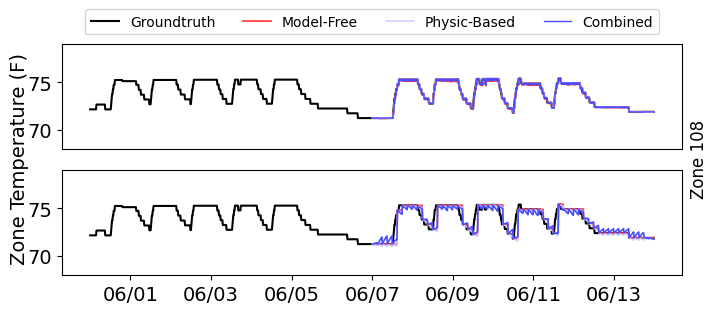

In [ ]:
import matplotlib.pyplot as plt
model_names = ['D1','P1','C1']
model_names2 = ['Model-Free', 'Physic-Based',  'Combined']
colors = ['#ff3534', '#ccccff',  '#4c4cff',  '#ef857e']
model = PhysicODE().to(device)
alphas = [1, 1, 1]
lims = [68, 79]
h = [1, 48]
fig, ax = plt.subplots(2,1, figsize=(8,3))
room = 2
r = 0
model_set_1 = [model_D_room_2_hori_15m, model_P_room_2_hori_15m, model_C_room_2_hori_15m]
model_set_2 = [model_D_room_2_hori_3h, model_P_room_2_hori_3h, model_C_room_2_hori_3h]
for i, length in enumerate([2, 12]):
    dataset = BuildingDataset(file='control_data.npz', room=room, N_train=14, length=length, resolution=3, train=False)
    dataloader = DataLoader(dataset, batch_size=20000, shuffle=False)
    for j in range(3):
        model_name = model_names[j]
        if length == 2:
          model = model_set_1[j]
        else:
          model = model_set_2[j]
        t = torch.linspace(0, length, length)
        for x0, y, truex in dataloader:
            y = y.permute(1, 0, 2)
            truex = truex.permute(1, 0, 2)
            predx = model(x0, y, t, name=model_name) # L, B, 2
            break
        predx = predx.detach().numpy()
        truex = truex.detach().numpy()
        y = y.detach().numpy()
        if j == 0:
            ax[i].plot(transform(truex, day=14, length=length), color='black', label='Groundtruth', linewidth=1.5)

        ax[i].plot(np.arange(672, 672*2), transform(predx, day=14, length=length)[672:], color=colors[j], alpha=alphas[j], linewidth=1.2-0.1*j*(i==0), label=model_names2[j])
        if i == 1:
            print(model_names2[j], np.mean(np.square(transform(predx, day=14, length=length)-transform(truex, day=14, length=length))))
    ax[i].set_xticks([])
    ax[i].set_ylim(lims)
    ax[i].tick_params(labelsize=14)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=5)
fig.text(0.06, 0.5, 'Zone Temperature (F)', va='center', rotation='vertical', fontsize=14)
fig.text(0.91, 0.5, 'Zone 108', va='center', rotation='vertical', fontsize=12)
tick_positions = list(range(96, 96*14, 96*2))
tick_labels = ['06/01','06/03','06/05','06/07', '06/09','06/11', '06/13']
ax[-1].set_xticks(tick_positions, tick_labels, fontsize=14)
plt.savefig('predict.png', dpi=300, bbox_inches='tight')